# Predicting Higgs Bosons With Machine Learning

<img src="http://cds.cern.ch/record/2313709/files/run314472_event53576477_v3.png?subformat=icon-640">

<sup><cite>CMS-PHO-EVENTS-2018-002-6. (CERN 2018). http://cds.cern.ch/record/2313709.</cite></sup>

In 2014, the paper [Searching for Exotic Particles in High-Energy Physics with Deep Learning](https://arxiv.org/pdf/1402.4735) (P. Baldi, P. Sadowski, and D. Whiteson of UC, Irvine) discusses how to use machine learning to predict Higgs Boson particles using various measurements that are taken from a particle collider. 11M collisions were simulated to see if these measurements can be used to distinguish between a particle of interest (signal) or background particles. There are two main feature sets that are used:

1. Low-level features: These are raw measurements from a particle accelerator.
2. High-level features: These are manually derived from the raw inputs. This is fairly labor-intensive.

The researchers were able to successfully improve the Area Under the Curve (AUC) using deep learning and a combination of the low-level and high-level features produced from these simulated collisions. If it is possible to create predictions with low-level features that are equal to or better than high-level features, then time can be saved by not spending time deriving the high-level features. In the paper, they were able to prove that a deep neural network did as well learning from low-level features as it did with the complete feature set. Deep neural networks require more feature engineering, thoughtful architecture, and GPUs to train efficiently.

**Project Goals**
1. Create a tuned machine learning model with low-level features that are as good or better than high-level features
2. Build a model that is equal to or better than the Boosted Decision Tree (BDT) or shallow Neural Network (NN) models in the paper
3. Determine which features are the best predictors
4. Use equivalent hardware without the need of a GPU

**Topics**
- Machine Learning
- Hyperparameter Autotuning
- Big Data
- Visualization

**References**

<cite>Whiteson, D. (2014). HIGGS [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5V312.</cite>

<cite>Baldi, P., Sadowski, P., & Whiteson, D. (2014, June 5). Searching for exotic particles in high-energy physics with Deep Learning. arXiv.org. https://arxiv.org/abs/1402.4735</cite>

In [ ]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import optuna.visualization as vis
import plotly.io as pio
import warnings
from pathlib import Path
from zipfile import ZipFile
from isal import igzip
from sasviya.ml.linear_model import LogisticRegression
from sasviya.ml.svm import SVC
from sasviya.ml.tree import DecisionTreeClassifier, ForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (roc_auc_score, roc_curve, RocCurveDisplay, 
                             classification_report, accuracy_score, confusion_matrix,
                             ConfusionMatrixDisplay
                            )

warnings.filterwarnings(action='ignore', category=FutureWarning)

# Make output a little cleaner
pl.Config.set_tbl_rows(100)
pl.Config.set_tbl_cols(20)
pl.Config.set_tbl_hide_column_data_types(True)

# Location of accuracy and hyperparameter optimization studies
study_loc = Path.cwd() / 'studies'

### Read Data

Read in the higgs dataset. This dataset can be found at the UC Irvine Machine Learning repository:
https://archive.ics.uci.edu/dataset/280/higgs

It is a csv file in a gz file encapsulated in a zip file. We'll need to unwrap everything to get to the csv file.

If you are running this interactively but do not want to perform EDA, run the code block below, then [skip to data prep](#prepdata).

In [ ]:
file = '/workspaces/myfolder/data/higgs.zip'

col_names = [
    'signal', 'lepton_pt', 'lepton_eta', 'lepton_phi', 
    'missing_energy_magnitude', 'missing_energy_phi',
    'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_btag',
    'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_btag',
    'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_btag',
    'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_btag',
    'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'
]
             
with ZipFile(file, 'r') as zip_file:
    with zip_file.open('HIGGS.csv.gz') as gz_file:
        with igzip.open(gz_file, 'rt') as csv_file:
            df = pl.read_csv(csv_file, has_header=False, new_columns=col_names)
            
df_sample = df.sample(1000, seed=42)

X = df.drop('signal')
y = df['signal']

### Exploratory Data Analysis

Let's take a look at the underlying data and see how it all looks. The data is entirely numeric, has no missing values, is well-balanced with a 53/47 split, and almost all variables have a low correlation with each other. It's excellent for machine learning.

**General statistics**

In [ ]:
df.describe().transpose(include_header=True, column_names='statistic')

column,count,null_count,mean,std,min,25%,50%,75%,max
"""signal""",1.1e7,0.0,0.52992,0.499104,0.0,0.0,1.0,1.0,1.0
"""lepton_pt""",1.1e7,0.0,0.991466,0.565378,0.274697,0.590753,0.853371,1.236226,12.098914
"""lepton_eta""",1.1e7,0.0,-0.000008,1.008827,-2.434976,-0.738322,-0.000054,0.738214,2.434868
"""lepton_phi""",1.1e7,0.0,-0.000013,1.006346,-1.742508,-0.871931,-0.000241,0.870994,1.743236
"""missing_energy_magnitude""",1.1e7,0.0,0.998536,0.600018,0.000237,0.576816,0.891628,1.293056,15.396821
"""missing_energy_phi""",1.1e7,0.0,0.000026,1.006326,-1.743944,-0.871208,0.000213,0.871471,1.743257
"""jet_1_pt""",1.1e7,0.0,0.990915,0.474975,0.137502,0.678993,0.894819,1.17074,9.940391
"""jet_1_eta""",1.1e7,0.0,-0.00002,1.009303,-2.969725,-0.687245,-0.000025,0.687194,2.969674
"""jet_1_phi""",1.1e7,0.0,0.000008,1.005901,-1.741237,-0.868096,0.000058,0.868313,1.741454
"""jet_1_btag""",1.1e7,0.0,0.999969,1.027808,0.0,0.0,1.086538,2.173076,2.173076


**Check the balance of signal**

In [ ]:
df['signal'].value_counts(normalize=True)

signal,proportion
1.0,0.52992
0.0,0.47008


**Correlation Matrix**

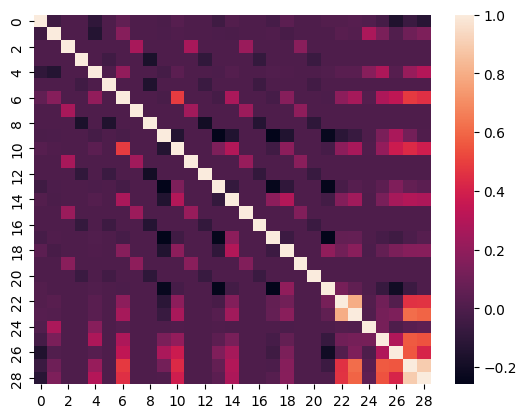

In [ ]:
sns.heatmap(df.corr());

**Distribution of low-level variables**
- `lepton_eta`
- `jet1_pt`
- `jet2_pt`
- `jet3_pt`
- `jet4_pt`

In [ ]:
def make_dis_plots(df, vars, cols):
    n_vars = len(vars)
    n_cols = cols
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    axes = axes.flatten()

    for i, var in enumerate(vars):
        sns.histplot(df[var], kde=True, ax=axes[i])
        axes[i].set_title(var)
        axes[i].set_xlabel('')

    # Delete unused plots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

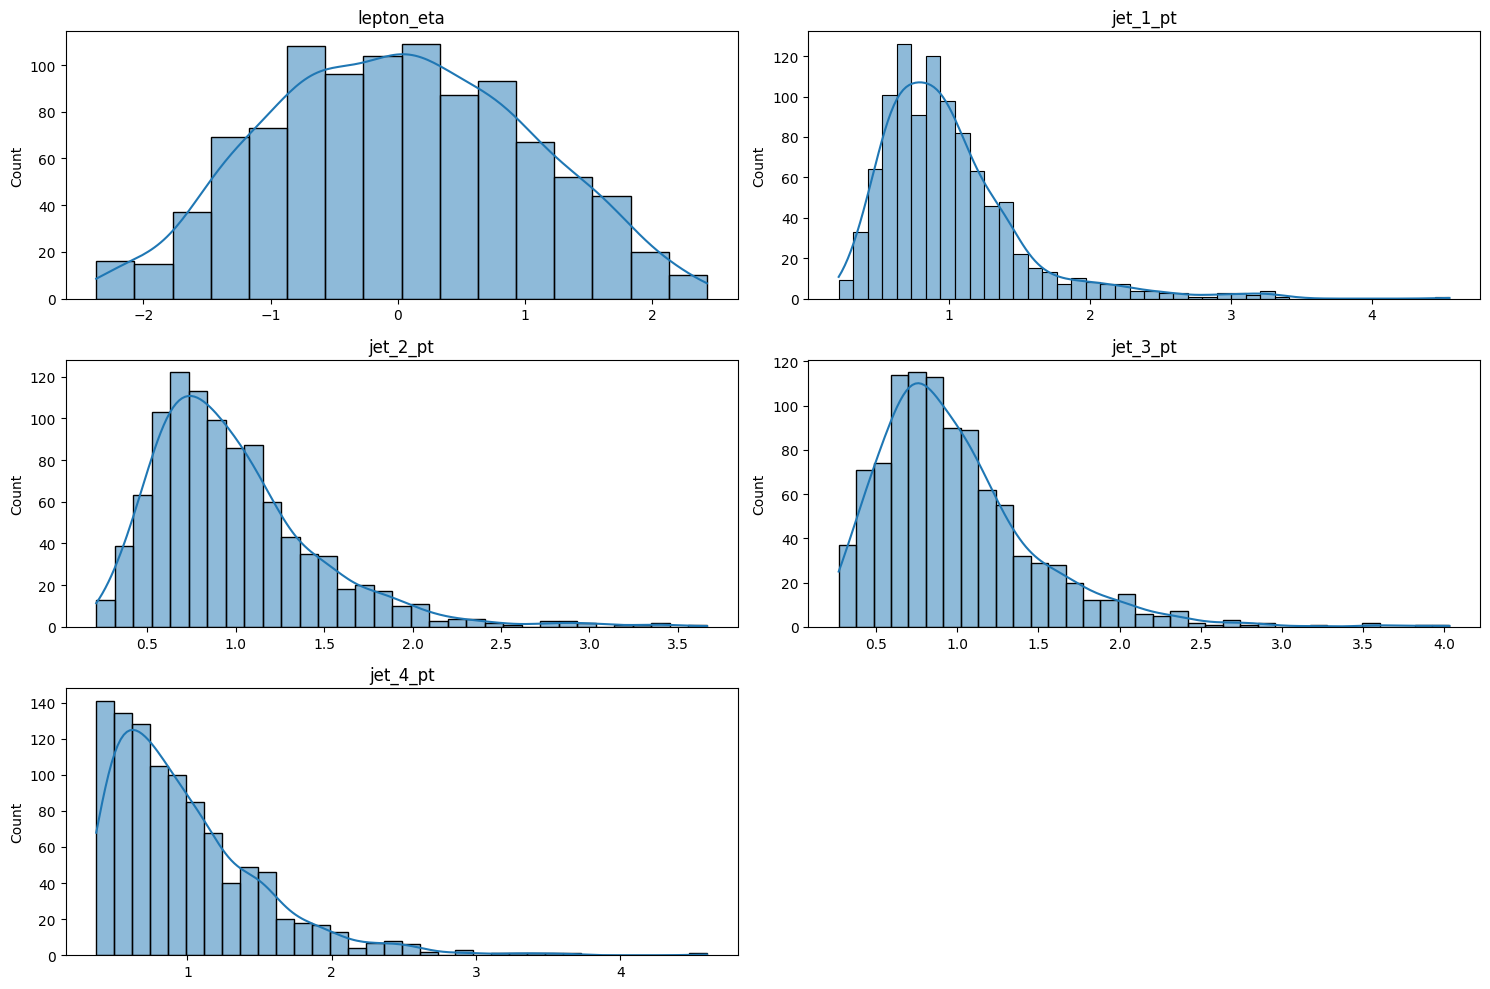

In [ ]:
vars = ['lepton_eta', 'jet_1_pt', 'jet_2_pt', 'jet_3_pt', 'jet_4_pt']
make_dis_plots(df_sample, vars, 2)

**Distribution of all high-level variables**
- `m_jj`
- `m_jjj`
- `m_lv`
- `m_jlv`
- `m_bb`
- `m_wbb`
- `m_wwbb`

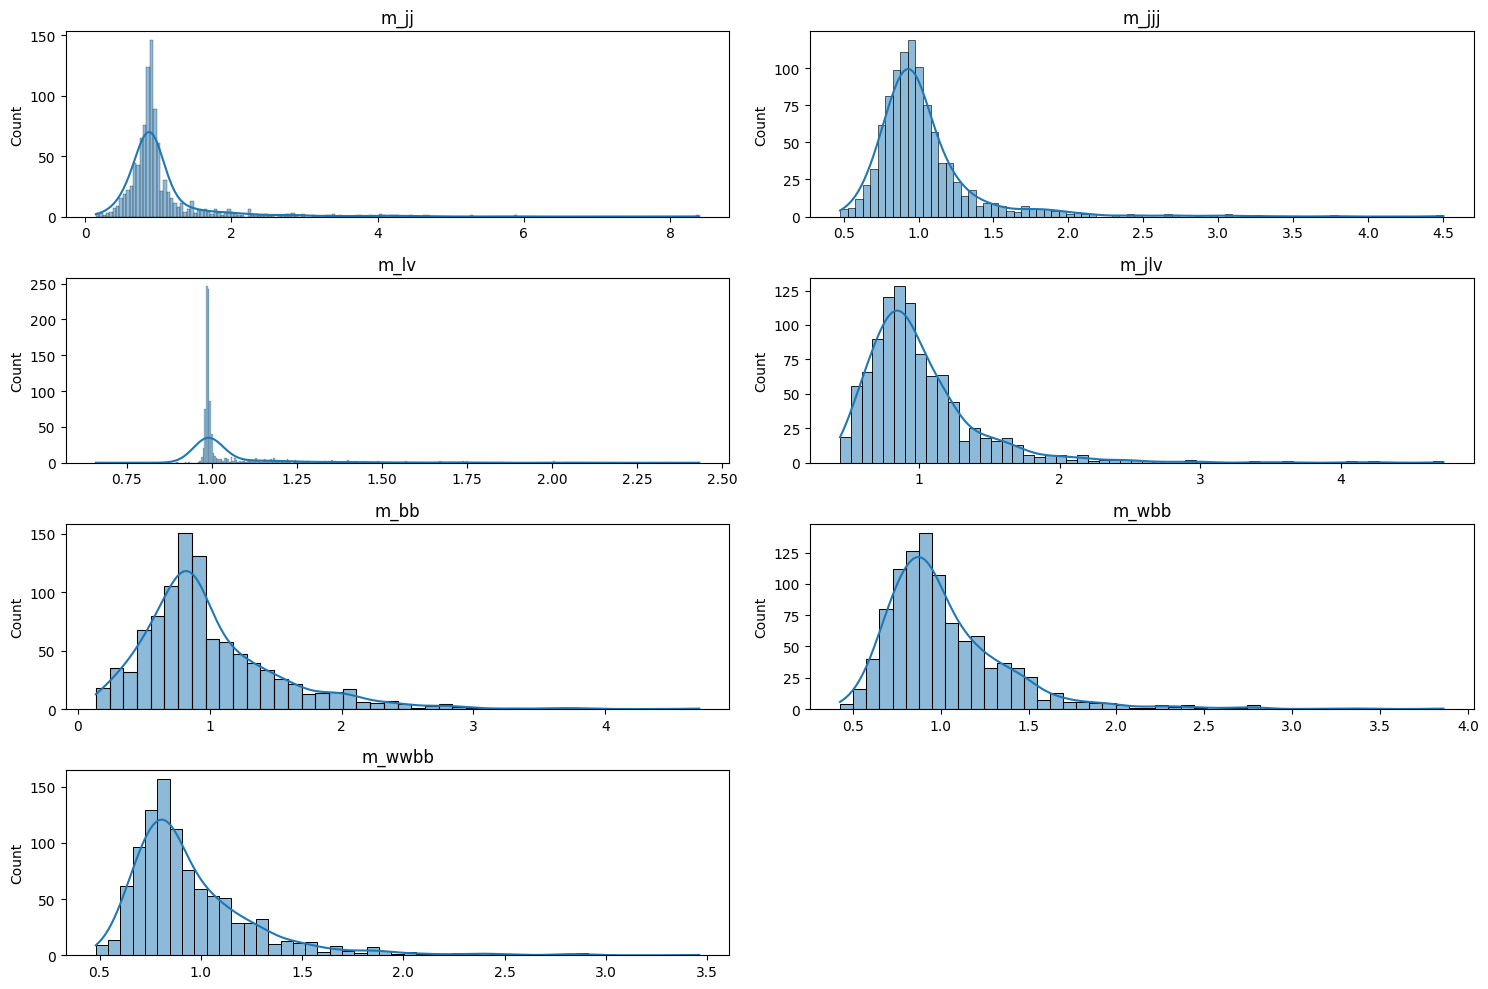

In [ ]:
vars = ['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

make_dis_plots(df_sample, vars, 2)

### Preliminary Model Selection

We have a lot of models to choose from, and we want to narrow it down to one. We'll do a preliminary test using 5-fold cross-validation using the following models:

- Logistic Regression
- SVC
- Decision Tree
- Random Forest
- Gradient Boosting

This will give us a good starting point for a model to tune later. 

**This may take some time to run on the full dataset, so consider skipping running this and use the saved accuracy results instead. Or, run a sample of the data. To run a test, you must change test to True.**

In [ ]:
# Set to True to run
test = False

if test == True:
    models = [
        ('Logistic Regression', make_pipeline(StandardScaler(), LogisticRegression()) ),
        ('SVM', make_pipeline(StandardScaler(), SVC()) ),
        ('Decision Tree', DecisionTreeClassifier()), 
        ('Random Forest', ForestClassifier()),
        ('Gradient Boosting', GradientBoostingClassifier()),
    ]

    X_pd = X.to_pandas()
    y_pd = y.to_pandas()

    folds = 5

    print(f'Testing {folds}-fold cross-validation accuracy for {len(models)} models\n')
    
    i = 0
    scores = {}

    for name, model in models:
        i+=1

        print(f'{i}: {name}')
        scores[name]  = cross_val_score(model, X_pd, y_pd, cv=folds)
        
    df_accuracy  = pl.DataFrame(scores)
    df_accuracy.write_parquet(study_loc / 'accuracy.parquet')

    del X_pd, y_pd
else:
    print('No initial model test was run. Change test to True to run a model test.')

Testing 5-fold cross-validation accuracy for 5 models

1: Logistic Regression
2: SVM
3: Decision Tree
4: Random Forest
5: Gradient Boosting


### Review preliminary accuracy results

We're looking for the model that has the best prediction accuracy on average, and we want to see what the standard deviation is throughout each fold. Given that the data is very balanced, we should expect that there is low variance.

In [ ]:
df_accuracy = pl.read_parquet(study_loc / 'accuracy.parquet')
df_accuracy

Logistic Regression,SVM,Decision Tree,Random Forest,Gradient Boosting
0.566126,0.562287,0.577392,0.619178,0.63322
0.566264,0.562161,0.578423,0.622332,0.633713
0.566528,0.562504,0.578295,0.620902,0.633915
0.56622,0.56261,0.576849,0.623043,0.633438
0.566327,0.56281,0.577996,0.619879,0.633706


In [ ]:
df_accuracy.describe().transpose(include_header=True, column_names='statistic')

column,count,null_count,mean,std,min,25%,50%,75%,max
"""Logistic Regression""",5.0,0.0,0.566293,0.00015,0.566126,0.56622,0.566264,0.566327,0.566528
"""SVM""",5.0,0.0,0.562474,0.000258,0.562161,0.562287,0.562504,0.56261,0.56281
"""Decision Tree""",5.0,0.0,0.577791,0.00066,0.576849,0.577392,0.577996,0.578295,0.578423
"""Random Forest""",5.0,0.0,0.621067,0.001621,0.619178,0.619879,0.620902,0.622332,0.623043
"""Gradient Boosting""",5.0,0.0,0.633599,0.000271,0.63322,0.633438,0.633706,0.633713,0.633915


In [ ]:
df_accuracy_stats = (
  df_accuracy
  .describe()
  .transpose(include_header=True, column_names='statistic')[['column', 'mean', 'std']]
  .sort('mean', descending=True)
)

df_accuracy_stats

column,mean,std
"""Gradient Boosting""",0.633599,0.000271
"""Random Forest""",0.621067,0.001621
"""Decision Tree""",0.577791,0.00066
"""Logistic Regression""",0.566293,0.00015
"""SVM""",0.562474,0.000258


**Gradient boosting is the clear winner here, and it has virtually no variance among all 5 folds.**

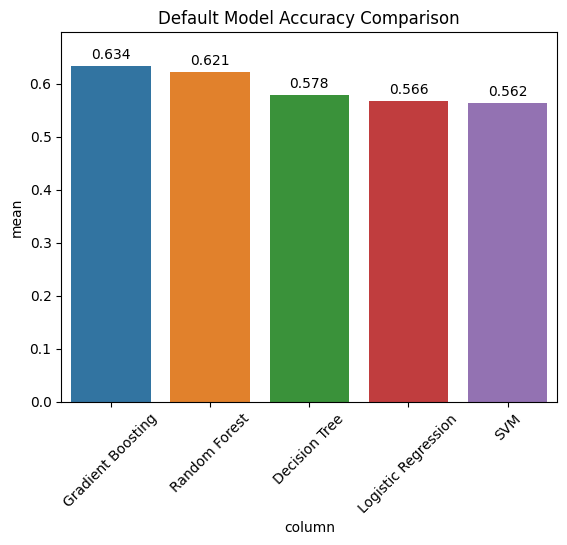

In [ ]:
ax = sns.barplot(
    data=df_accuracy_stats.to_pandas(),
    x='column', 
    y='mean'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

# Add a 10% buffer for bar values
ax.set_ylim(0, df_accuracy_stats['mean'].max() * 1.10)

plt.title('Default Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

### Prepare for tuning
<a id='prepdata'></a>
Split into train/validation/test:
- 70% Training
- 15% Validation
- 15% Test

We will tune against the validation dataset, then use the test dataset as our unbiased final measure of accuracy for generalization.

If you are running this interactively but do not want to autotune, run the code block below, then [skip to study results](#studyresults).

In [ ]:
high_level = ['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

X_train, X_temp, y_train, y_temp = train_test_split(X.to_pandas(), y.to_pandas(), test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Training/Validation/Test Split for low-level features
X_train_low  = X_train.drop(high_level, axis=1)
X_val_low    = X_val.drop(high_level, axis=1)
X_test_low   = X_test.drop(high_level, axis=1)

# Training/Validation/Test Split for high-level features
X_train_high = X_train[high_level]
X_val_high   = X_val[high_level]
X_test_high  = X_test[high_level]

# Clear up memory
del df, df_sample, X, y, X_train, X_val, X_test, X_temp, y_temp

**Confirm that the train/test/split is stratified with equal proportions**

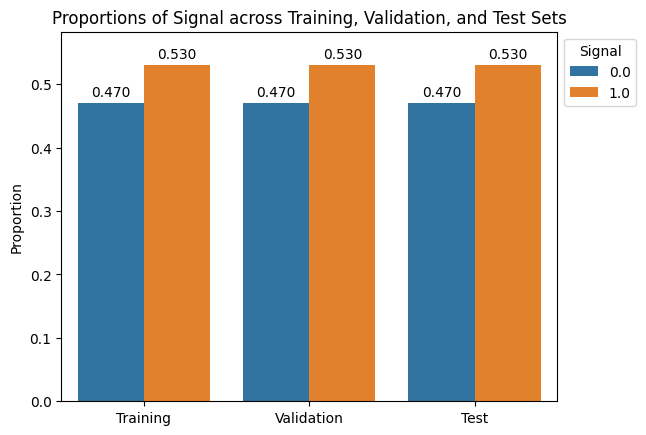

In [ ]:
y_train_props = y_train.value_counts(normalize=True).reset_index(name='Proportion')
y_train_props['Dataset'] = 'Training'

y_val_props = y_val.value_counts(normalize=True).reset_index(name='Proportion')
y_val_props['Dataset'] = 'Validation'

y_test_props = y_test.value_counts(normalize=True).reset_index(name='Proportion')
y_test_props['Dataset'] = 'Test'

all_proportions = pd.concat([y_train_props, y_val_props, y_test_props])

ax = sns.barplot(data=all_proportions, x='Dataset', y='Proportion', hue='signal');

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

# Add a 10% buffer for bar values
ax.set_ylim(0, all_proportions['Proportion'].max() * 1.10)

plt.title('Proportions of Signal across Training, Validation, and Test Sets')
plt.xlabel('')
plt.ylabel('Proportion')
plt.legend(title='Signal', loc='upper left', bbox_to_anchor=(1, 1));

### Autotune

We will autotune the models using Optuna, a Bayesian optimization hyperparameter autotuning framework. We will tune this using two models:

1. A model that only uses low-level variables
2. A model that only uses high-level variables

The goal is to see if we can make the low-level model as good, or better, than the high-level model. If we can tune it well enough, and ensure it is generalizable, then there is no need to go through the effort of deriving the high-level variables since the model has learned enough from the low-level variables to get equivalent or better predictions.

Our tuning method is to:
1. Train the model on the training dataset
2. Predict against the validation dataset
3. Calculate the Area Under the Curve (AUC)
4. Try to maximize the AUC

**These models have already been tuned and the study results are saved in the studies folder. Tuning will take time to complete. To tune a model, you must change tune to True. [Skip to study results](#studyresults).**

**Low-level autotuning**

In [ ]:
def low_level_objective(trial):
    n_bins           = trial.suggest_int('n_bins', 10, 100, step=5)
    n_estimators     = trial.suggest_int('n_estimators', 50, 300, step=10)
    max_depth        = trial.suggest_int('max_depth', 5, 17)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 100, 1000, step=50)
    learning_rate    = trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01)

    model = GradientBoostingClassifier(
        n_bins           = n_bins,
        n_estimators     = n_estimators,
        max_depth        = max_depth,
        min_samples_leaf = min_samples_leaf,
        learning_rate    = learning_rate,
        random_state     = 42
    )

    model.fit(X_train_low, y_train)
    
    preds = model.predict_proba(X_val_low).iloc[:,1]
    auc   = roc_auc_score(y_val, preds)

    return auc

In [ ]:
# Set to True to run
tune = False

if tune == True:
    low_level_study = optuna.create_study(
        direction  = 'maximize', 
        study_name = 'Low-level variables: Gradient Boosting Autotuning',
        storage    = f"sqlite:////{study_loc / 'low_level_study.db'}",
        load_if_exists=True
    )

    low_level_study.optimize(low_level_objective, n_trials=30)
else:
    print('Hyperparameter Autotuning was not run. Change tune to True to autotune hyperparameters.')

**High-level autotuning**

In [ ]:
def high_level_objective(trial):
    n_bins           = trial.suggest_int('n_bins', 10, 100, step=5)
    n_estimators     = trial.suggest_int('n_estimators', 50, 300, step=10)
    max_depth        = trial.suggest_int('max_depth', 5, 17)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 100, 1000, step=50)
    learning_rate    = trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01)

    model = GradientBoostingClassifier(
        n_bins           = n_bins,
        n_estimators     = n_estimators,
        max_depth        = max_depth,
        min_samples_leaf = min_samples_leaf,
        learning_rate    = learning_rate,
        random_state     = 42
    )

    model.fit(X_train_high, y_train)
    
    preds = model.predict_proba(X_val_high).iloc[:,1]
    auc   = roc_auc_score(y_val, preds)

    return auc

In [ ]:
# Set to True to run
tune = False

if tune == True:
    high_level_study = optuna.create_study(
        direction  = 'maximize', 
        study_name = 'High-level variables: Gradient Boosting Autotuning',
        storage    = f"sqlite:////{study_loc / 'high_level_study.db'}",
        load_if_exists=True    
    )

    high_level_study.optimize(high_level_objective, n_trials=30)
else:
    print('Hyperparameter Autotuning was not run. Change tune to True to autotune hyperparameters.')

**Check Study Results**<a id='studyresults'></a>

In [ ]:
low_level_study = optuna.load_study(
    storage=f"sqlite:////{study_loc / 'low_level_study.db'}",
    study_name='Low-level variables: Gradient Boosting Autotuning'
)

high_level_study = optuna.load_study(
    storage=f"sqlite:////{study_loc / 'high_level_study.db'}",
    study_name='High-level variables: Gradient Boosting Autotuning'
)

**Best parameters: Low-level variables**

In [ ]:
low_level_study.best_params

{'n_bins': 85,
 'n_estimators': 300,
 'max_depth': 16,
 'min_samples_leaf': 250,
 'learning_rate': 0.060000000000000005}

**Best parameters: High-level variables**

In [ ]:
high_level_study.best_params

{'n_bins': 100,
 'n_estimators': 240,
 'max_depth': 13,
 'min_samples_leaf': 250,
 'learning_rate': 0.060000000000000005}

### Explore Hyperparameter Autotuning Results

Optuna comes with some really cool visualizations out of the box. We can look and see which variables were considered most important for tuning as well as the optimization history.

**Note: These use Plotly and will not display on GitHub**

**Low-level study hyperparameter importances**

In [ ]:
vis.plot_param_importances(low_level_study).show()

**High-level study hyperparameter importances**

In [ ]:
vis.plot_param_importances(high_level_study).show()

**Low-level study optimization history**

In [ ]:
vis.plot_optimization_history(low_level_study)

**High-level study optimization history**

In [ ]:
vis.plot_optimization_history(high_level_study)

**Low-level study parallel coordinates plot**

In [ ]:
vis.plot_parallel_coordinate(low_level_study).show()

**High-level study parallel coordinates plot**

In [ ]:
vis.plot_parallel_coordinate(high_level_study).show()

### Fit All Models

We will fit four models:
1. Default low
2. Default high
3. Tuned low
4. Tuned high

By including the default model, this will give us a good baseline to compare against.

In [ ]:
# Set to True to calculate feature importances for tuned models. This will greatly increase training time.
calc_feature_importances = False 

gboost_model_default_low  = GradientBoostingClassifier(random_state=42)
gboost_model_default_high = GradientBoostingClassifier(random_state=42)

gboost_model_tuned_low  = GradientBoostingClassifier(
    **low_level_study.best_params, 
    random_state=42, 
    calc_feature_importances=calc_feature_importances
)

gboost_model_tuned_high = GradientBoostingClassifier(
    **high_level_study.best_params, 
    random_state=42, 
    calc_feature_importances=calc_feature_importances
)

gboost_model_default_low.fit(X_train_low, y_train)
gboost_model_default_high.fit(X_train_high, y_train)

gboost_model_tuned_low.fit(X_train_low, y_train)
gboost_model_tuned_high.fit(X_train_high, y_train)

# Save feature importance results
if calc_feature_importances == True:
    gboost_model_tuned_low.feature_importances_.to_parquet(
        study_loc / 'gboost_model_tuned_low_importances.parquet'
    )
    
    gboost_model_tuned_high.feature_importances_.to_parquet(
        study_loc / 'gboost_model_tuned_high_importances.parquet'
    )

#### Generate predictions

Create validation and test predictions for each model type:
- Default low-level features
- Default high-level features
- Tuned low-level features
- Tuned high-level features

In [ ]:
val_preds = pd.DataFrame(
    {
        'signal': y_val,
        'p_signal_default_low':  gboost_model_default_low.predict_proba(X_val_low).iloc[:,1],
        'p_signal_default_high': gboost_model_default_high.predict_proba(X_val_high).iloc[:,1],
        'p_signal_tuned_low':    gboost_model_tuned_low.predict_proba(X_val_low).iloc[:,1],
        'p_signal_tuned_high':   gboost_model_tuned_high.predict_proba(X_val_high).iloc[:,1]
    }
)

test_preds = pd.DataFrame(
    {
        'signal': y_test,
        'p_signal_default_low':  gboost_model_default_low.predict_proba(X_test_low).iloc[:,1],
        'p_signal_default_high': gboost_model_default_high.predict_proba(X_test_high).iloc[:,1],
        'p_signal_tuned_low':    gboost_model_tuned_low.predict_proba(X_test_low).iloc[:,1],
        'p_signal_tuned_high':   gboost_model_tuned_high.predict_proba(X_test_high).iloc[:,1]
    }
)

#### Calculate ROC curves

In [ ]:
# Create a map of models and titles
models = {
    'p_signal_default_low':  'Default Low-level Model',
    'p_signal_default_high': 'Default High-level Model',
    'p_signal_tuned_low':    'Tuned Low-level Model' ,
    'p_signal_tuned_high':   'Tuned High-level Model'
}

# Run each model through roc_curve and roc_auc_score,
# then append the results to a single row that holds
# the name, model, split, ROC curve and AUC.
# Splits are in propcase for titles later.
rows  = []

for model in models:
    roc_results[model] = {}
    
    for split in ['Val', 'Test']:
        if split == 'Val':
            y_true = y_val
            preds  = val_preds 
        else:
            y_true = y_test
            preds  = test_preds

        fpr, tpr, thresholds = roc_curve(y_true, preds[model])
        auc = roc_auc_score(y_true, preds[model])
        
        rows.append(
            {
                'name': models[model],
                'model': model,
                'split': split,
                'auc': auc,
                'fpr': fpr,
                'tpr': tpr,
            }
        )

roc_df = pd.DataFrame(rows)
roc_df

,name,model,split,auc,fpr,tpr
0,Default Low-level Model,p_signal_default_low,Val,0.685340,"[0.0, 0.0, 0.0, 1.2892728629979978e-06, 1.2892...","[0.0, 1.143681900890814e-06, 0.000100644007278..."
1,Default Low-level Model,p_signal_default_low,Test,0.685531,"[0.0, 0.0, 0.0, 1.2892712007756255e-06, 1.2892...","[0.0, 1.1436832089006002e-06, 6.97646757429366..."
2,Default High-level Model,p_signal_default_high,Val,0.776665,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.143681900890814e-06, 2.630468372048871..."
3,Default High-level Model,p_signal_default_high,Test,0.776714,"[0.0, 0.0, 0.0, 1.2892712007756255e-06, 1.2892...","[0.0, 1.1436832089006002e-06, 6.86209925340360..."
4,Tuned Low-level Model,p_signal_tuned_low,Val,0.794159,"[0.0, 0.0, 0.0, 1.2892728629979978e-06, 1.2892...","[0.0, 1.143681900890814e-06, 0.000153253374719..."
5,Tuned Low-level Model,p_signal_tuned_low,Test,0.794608,"[0.0, 0.0, 0.0, 1.2892712007756255e-06, 1.2892...","[0.0, 1.1436832089006002e-06, 0.00072966988727..."
6,Tuned High-level Model,p_signal_tuned_high,Val,0.796049,"[0.0, 0.0, 0.0, 1.2892728629979978e-06, 1.2892...","[0.0, 1.143681900890814e-06, 6.290250454899476..."
7,Tuned High-level Model,p_signal_tuned_high,Test,0.795784,"[0.0, 0.0, 0.0, 1.2892712007756255e-06, 1.2892...","[0.0, 1.1436832089006002e-06, 0.00013838566827..."


### Plot ROC Curves and Accuracy

With a **Test AUC of 0.795**, the low-level model is nearly as good as the high-level model with a **Test AUC of 0.796**. Both models beat the default model with a **Test AUC of 0.69**, and even beat both the paper's BDT and shallow NN models.

| Model            | AUC: Low-level  | AUC: High-level |
| ---------------- | --------------- | --------------- |
| Paper: BDT       | 0.73            | 0.78            |
| Paper: NN        | 0.733           | 0.777           |
| Paper: DN        | 0.880           | 0.885           |
| Default GBoost   | 0.686           | 0.777           |
| **Tuned GBoost** | **0.795**       | **0.796**       |

The validation and test results show identical AUCs, suggesting excellent generalization of this model. This means it is possible to create a tuned gradient boosting model in short time without the need of GPU acceleration for deep learning to create a model that is more accurate than the paper's BDT and shallow NN.

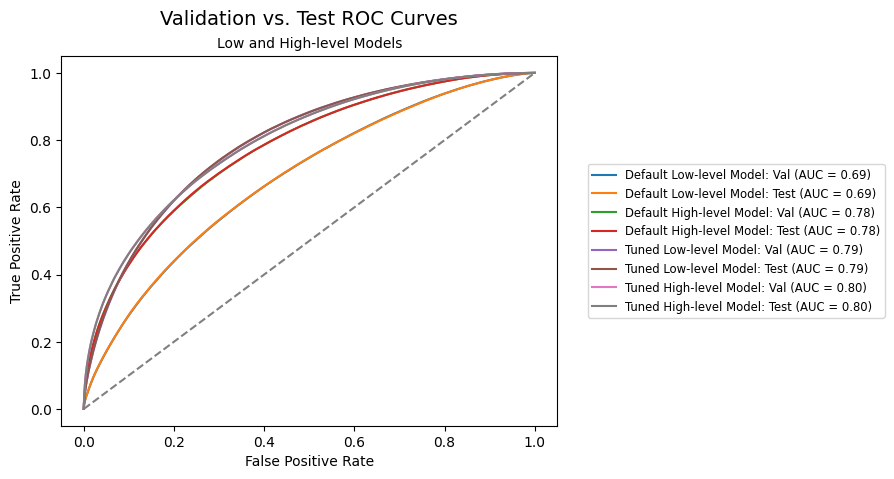

In [ ]:
roc_curves = {}

# This converts the DataFrame into a dictionary that's easy to work 
# with for passing into RocCurveDisplay:
# {'Default Low-level Model', {'Val': <roc curve object>, 'Test': <roc_curve_object>},
#  'Default High-level Model', {'Val': <roc curve object>, 'Test': <roc_curve_object>},
#  'Tuned Low-level Model', {'Val': <roc curve object>, 'Test': <roc_curve_object>},
#  'Tuned High-level Model', {'Val': <roc curve object>, 'Test': <roc_curve_object>}
# }

for _, row in roc_df.iterrows():
    name  = row['name']
    split = row['split']

    if name not in roc_curves:
        roc_curves[name] = {}

    roc_curves[name][split] = RocCurveDisplay(
        fpr=row['fpr'],
        tpr=row['tpr'],
        roc_auc=row['auc']
    )

fig, ax = plt.subplots()

for name, splits in roc_curves.items():
    for split, roc_curve in splits.items():
        roc_curve.plot(ax=ax, name=f'{name}: {split}')

ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize='small')

# Add a subtitle. ax.text acts as the title in this case.
ax.text(0.5, 1.10, 'Validation vs. Test ROC Curves', fontsize=14, ha='center', va='center', transform=ax.transAxes)
ax.set_title('Low and High-level Models', fontsize=10)

plt.show()

**Accuracy Score of all models**

In [ ]:
scenarios = [
    ('Validation, default low-level model', val_preds, 'p_signal_default_low'),
    ('Test, default low-level model', test_preds, 'p_signal_default_low'),
    ('Validation, default high-level model', val_preds, 'p_signal_default_high'),
    ('Test, default high-level model', test_preds, 'p_signal_default_high'),
    ('Validation, tuned low-level model', val_preds, 'p_signal_tuned_low'),
    ('Test, tuned low-level model', test_preds, 'p_signal_tuned_low'),
    ('Validation, tuned high-level model', val_preds, 'p_signal_tuned_high'),
    ('Test, tuned high-level model', test_preds, 'p_signal_tuned_high')
]

for label, df, pred_col in scenarios:
    score = accuracy_score(df['signal'], (df[pred_col] >= 0.5).astype(int))
    print(f'Accuracy score: {label}\n    {score:.4f}\n')

Accuracy score: Validation, default low-level model
    0.6326

Accuracy score: Test, default low-level model
    0.6331

Accuracy score: Validation, default high-level model
    0.7010

Accuracy score: Test, default high-level model
    0.7016

Accuracy score: Validation, tuned low-level model
    0.7212

Accuracy score: Test, tuned low-level model
    0.7218

Accuracy score: Validation, tuned high-level model
    0.7165

Accuracy score: Test, tuned high-level model
    0.7161



**Tuned Low-level Model Confusion Matrices**

In [ ]:
def plot_confusion_matrix(df, title):
    fig, ax = plt.subplots()

    confusion_matrix_disp = ConfusionMatrixDisplay(
        confusion_matrix(
            df['signal'], 
            (df['p_signal_tuned_low'] >= 0.5).astype(int),
            normalize='true'
        )
    )

    confusion_matrix_disp.plot(cmap='magma', ax=ax);

    # Add a subtitle. ax.text acts as the title in this case.
    ax.text(0.5, 1.10, title, fontsize=14, ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Tuned Low-level Gradient Boosting Model', fontsize=10)
    ax.set_xlabel('Predicted Signal')
    ax.set_ylabel('True Signal')
    
    plt.show()

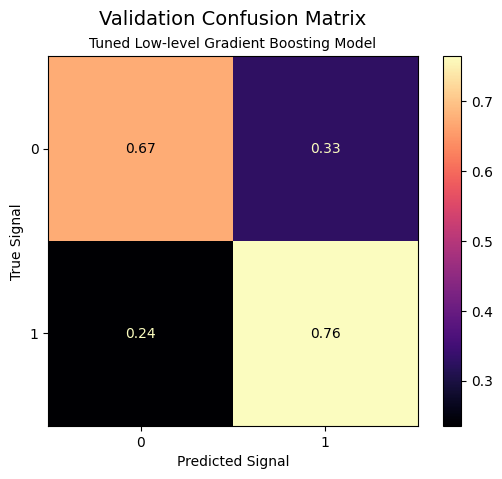

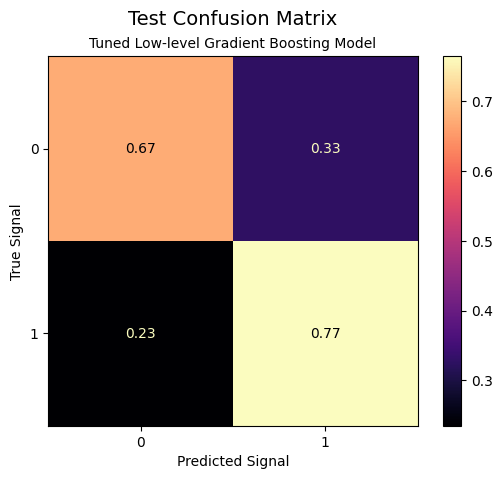

In [ ]:
plot_confusion_matrix(val_preds, 'Validation Confusion Matrix')
plot_confusion_matrix(test_preds, 'Test Confusion Matrix')

### Relative Variable Importance

Calculate the relative importance of each feature and display it in a normalized bar chart for the tuned low and high-level Gradient Boosting models. These values are scaled such that the most important feature has a value of 1.0, and all others are shown relative to it. For example, a feature with a relative importance of 0.95 is 95% as influential as the top-ranked feature in terms of the model’s internal decision-making. Relative importances are **only applicable to the specific model** and should not be compared across different models and types.

Features with low relative importance may contribute little to the model’s predictive power and could be candidates for removal. Removing these features can simplify the model and reduce training time, but it may reduce accuracy. Additional evaluation is needed to confirm whether they can be safely excluded.

In [ ]:
def plot_relative_importance(df, title):
    df_relative_importances = (
        ( df['Importance'] / df['Importance'].max() )
        .sort_values(ascending=False)
    )

    palette = [plt.get_cmap('Oranges')(value) for value in df_relative_importances]

    fig, ax = plt.subplots(constrained_layout=True)

    sns.barplot(
        orient='h',
        x=df_relative_importances, 
        y=df['Variable'],
        palette=palette
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)

    # Make room for values and add a subtitle. ax.text acts as the title in this case.
    ax.set_xlim(0, 1.10)
    ax.text(0.5, 1.10, title, fontsize=14, ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Tuned Gradient Boosting Model', fontsize=10)

    plt.show()

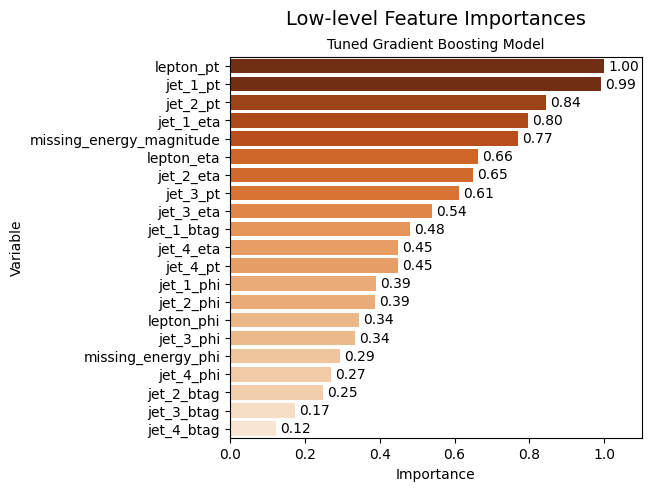

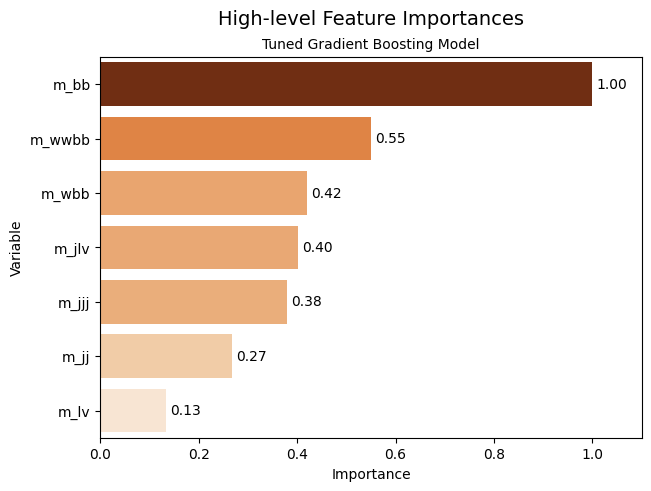

In [ ]:
df_tuned_low_feature_importances  = pd.read_parquet(study_loc / 'gboost_model_tuned_low_importances.parquet')
df_tuned_high_feature_importances = pd.read_parquet(study_loc / 'gboost_model_tuned_high_importances.parquet')

plot_relative_importance(df_tuned_low_feature_importances, 'Low-level Feature Importances')
plot_relative_importance(df_tuned_high_feature_importances, 'High-level Feature Importances')